# DL/ML Training

## Setup

In [ ]:
# essentials
from fastbook import *
from katlas.imports import *
from katlas.train import *
from katlas.dl import *
import seaborn as sns

# sklearn
from sklearn.neighbors import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.multioutput import MultiOutputRegressor

## Data

In [ ]:
# T5 data
t5_kd = pd.read_parquet('train_data/combine_t5_kd.parquet').reset_index()
t5 = pd.read_parquet('train_data/combine_t5.parquet').reset_index()

# ESM data
esm_kd = pd.read_parquet('train_data/combine_esm_kd.parquet').reset_index()
esm = pd.read_parquet('train_data/combine_esm.parquet').reset_index()

# feature col
t5_col = t5.columns[t5.columns.str.startswith('T5_')]
esm_col = esm.columns[esm.columns.str.startswith('esm_')]

# target col
target_col = t5.columns[~t5.columns.isin(t5_col)][1:] 

In [ ]:
t5_col,esm_col,target_col

(Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
        'T5_9',
        ...
        'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
        'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
       dtype='object', length=1024),
 Index(['esm_0', 'esm_1', 'esm_2', 'esm_3', 'esm_4', 'esm_5', 'esm_6', 'esm_7',
        'esm_8', 'esm_9',
        ...
        'esm_1270', 'esm_1271', 'esm_1272', 'esm_1273', 'esm_1274', 'esm_1275',
        'esm_1276', 'esm_1277', 'esm_1278', 'esm_1279'],
       dtype='object', length=1280),
 Index(['-5P', '-5G', '-5A', '-5C', '-5S', '-5T', '-5V', '-5I', '-5L', '-5M',
        ...
        '4Q', '4N', '4D', '4E', '4s', '4t', '4y', '0s', '0t', '0y'],
       dtype='object', length=210))

## Kfold Split

In [ ]:
source = pd.read_excel('train_data/combine_info_PSPA.xlsx').iloc[:,:2]

info = Data.get_kinase_info().query('pseudo !="1"')

info = source.merge(info,how='left')

In [ ]:
info[info.kinase.str.contains('MEK')]

,kinase,source,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
183,MEK1,PSPA,MAP2K1,Q02750,MAP2K1,STE,STE7,None,STE7,1,0,1,0,assorted,assorted,2.0,12.0,393,MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQRKRLEAFLTQKQKVGELKDDDFEKISELGAGNGGVVFKVSHKPSGLVMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKKAGRIPEQILGKVSIAVIKGLTYLREKHKIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMSPERLQGTHYSVQSDIWSMGLSLVEMAVGRYPIPPPDAKELELMFGCQVEGDAAETPPRPRTPGRPLSSYGMDSRPPMAIFELLDYIVNEPPPKLPSGVFSLEFQDFVNKCLIKNPAERADLKQLMVHAFIKRSDAEEVDFAGWLCSTIGLNQPSTPTHAAGV,FEKISELGAGNGGVVFKVSHKPSGLVMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKKAGRIPEQILGKVSIAVIKGLTYLREKHKIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMSPERLQGTHYSVQSDIWSMGLSLVEMAVGRYPIPPPDAKELELMFGCQVEGDAAETPPRPRTPGRPLSSYGMDSRPPMAIFELLDYIVNEPPPKLPSGVFSLEFQDFVNKCLIKNPAERADLKQLMVHAFI,NaN,7.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
184,MEK2,PSPA,MAP2K2,P36507,MAP2K2,STE,STE7,None,STE7,1,0,1,0,assorted,assorted,2.0,12.0,95,MLARRKPVLPALTINPTIAEGPSPTSEGASEANLVDLQKKLEELELDEQQKKRLEAFLTQKAKVGELKDDDFERISELGAGNGGVVTKVQHRPSGLIMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKEAKRIPEEILGKVSIAVLRGLAYLREKHQIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMAPERLQGTHYSVQSDIWSMGLSLVELAVGRYPIPPPDAKELEAIFGRPVVDGEEGEPHSISPRPRPPGRPVSGHGMDSRPAMAIFELLDYIVNEPPPKLPNGVFTPDFQEFVNKCLIKNPAERADLKMLTNHTFIKRSEVEEVDFAGWLCKTLRLNQPGTPTRTAV,FERISELGAGNGGVVTKVQHRPSGLIMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKEAKRIPEEILGKVSIAVLRGLAYLREKHQIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMAPERLQGTHYSVQSDIWSMGLSLVELAVGRYPIPPPDAKELEAIFGRPVVDGEEGEPHSISPRPRPPGRPVSGHGMDSRPAMAIFELLDYIVNEPPPKLPNGVFTPDFQEFVNKCLIKNPAERADLKMLTNHTFI,NaN,7.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
185,MEK5,PSPA,MAP2K5,Q13163,MAP2K5,STE,STE7,None,STE7,1,0,1,0,MAP3K,MAP3K,2.0,7.0,448,MLWLALGPFPAMENQVLVIRIKIPNSGAVDWTVHSGPQLLFRDVLDVIGQVLPEATTTAFEYEDEDGDRITVRSDEEMKAMLSYYYSTVMEQQVNGQLIEPLQIFPRACKPPGERNIHGLKVNTRAGPSQHSSPAVSDSLPSNSLKKSSAELKKILANGQMNEQDIRYRDTLGHGNGGTVYKAYHVPSGKILAVKVILLDITLELQKQIMSELEILYKCDSSYIIGFYGAFFVENRISICTEFMDGGSLDVYRKMPEHVLGRIAVAVVKGLTYLWSLKILHRDVKPSNMLVNTRGQVKLCDFGVSTQLVNSIAKTYVGTNAYMAPERISGEQYGIHSDVWSLGISFMELALGRFPYPQIQKNQGSLMPLQLLQCIVDEDSPVLPVGEFSEPFVHFITQCMRKQPKERPAPEELMGHPFIVQFNDGNAAVVSMWVCRALEERRSQQGPP,IRYRDTLGHGNGGTVYKAYHVPSGKILAVKVILLDITLELQKQIMSELEILYKCDSSYIIGFYGAFFVENRISICTEFMDGGSLDVYRKMPEHVLGRIAVAVVKGLTYLWSLKILHRDVKPSNMLVNTRGQVKLCDFGVSTQLVNSIAKTYVGTNAYMAPERISGEQYGIHSDVWSLGISFMEIQKNQGSLMPLQLLQCIVDEDSPVLPVGEFSEPFVHFITQCMRKQPKERPAPEELMGHPFI,3.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
186,MEKK1,PSPA,MAP3K1,Q13233,MAP3K1,STE,STE11,None,STE11,1,0,1,0,MAP3K,MAP3K,2.0,9.0,339,MAAAAGNRASSSGFPGARATSPEAGGGGGALKASSAPAAAAGLLREAGSGGRERADWRRRQLRKVRSVELDQLPEQPLFLAASPPASSTSPSPEPADAAGSGTGFQPVAVPPPHGAASRGGAHLTESVAAPDSGASSPAAAEPGEKRAPAAEPSPAAAPAGREMENKETLKGLHKMDDRPEERMIREKLKATCMPAWKHEWLERRNRRGPVVVKPIPVKGDGSEMNHLAAESPGEVQASAASPASKGRRSPSPGNSPSGRTVKSESPGVRRKRVSPVPFQSGRITPPRRAPSPDGFSPYSPEETNRRVNKVMRARLYLLQQIGPNSFLIGGDSPDNKYRVFIGPQNCSCARGTFCIHLLFVMLRVFQLEPSDPMLWRKTLKNFEVESLFQKYHSRRSSRIKAPSRNTIQKFVSRMSNSHTLSSSSTSTSSSENSIKDEEEQMCPICLLGMLDEESLTVCEDGCRNKLHHHCMSIWAEECRRNREPLICPLCRSKWRSHDFYSHELSSPVDSPSSLRAAQQQTVQQQPLAGSRRNQESNFNLTHYGTQQIPPAYKDLAEPWIQVFGMELVGCLFSRNWNVREMALRRLSHDVSGALL...,WLKGQQIGLGAFSSCYQAQDVGTGTLMAVKQVTYVRNTSSEQEEVVEALREEIRMMSHLNHPNIIRMLGATCEKSNYNLFIEWMAGGSVAHLLSKYGAFKESVVINYTEQLLRGLSYLHENQIIHRDVKGANLLIDSTGQRLRIADFGAAARLASKGTGAGEFQGQLLGTIAFMAPEVLRGQQYGRSCDVWSVGCAIIEMACAKPPWNAEKHSNHLALIFKIASATTAPSIPSHLSPGLRDVALRCLELQPQDRPPSRELLKHPVF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
187,MEKK2,PSPA,MAP3K2,Q9Y2U5,MAP3K2,STE,STE11,None,STE11,1,0,1,0,MAP3K,MAP3K,2.0,12.0,619,MDDQQALNSIMQDLAVLHKASRPALSLQETRKAKSSSPKKQNDVRVK

In [ ]:
map2 = t5[t5.kinase.str.contains('MEK')]

In [ ]:
map2 = map2.set_index('kinase')

In [ ]:
target = map2.loc[:,~map2.columns.str.contains('T5_')]

In [ ]:
target

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MEK1,-0.179089,-0.625424,0.190732,0.063208,-0.147207,-0.147207,-0.019683,-0.159960,-0.147207,-0.281108,3.091911,0.082336,0.101465,0.031327,-0.217346,-0.281108,-0.363999,-0.376751,0.375642,-0.121703,-0.230098,-0.230098,-0.408632,-0.760494,-0.414864,-0.056889,0.054206,-0.056889,-0.056889,0.165301,-0.198845,-0.451896,0.146786,0.072722,0.270225,0.344289,0.350461,-0.562991,-0.334628,-0.433380,-0.149469,0.406008,0.665231,0.449212,0.449212,0.103582,-1.220768,-1.155581,-0.130373,-0.130373,-0.130373,-0.130373,-0.408898,-0.207412,-0.130373,-0.124447,-0.047408,2.941334e-15,0.562975,0.053335,0.124447,1.060764,-0.480011,-0.965947,-0.142225,-0.183708,2.222272,2.222272,-0.657792,-1.346319,-0.609511,-0.105379,0.133761,-0.105379,-0.105379,-1.139495,-1.042547,-0.693533,0.204856,2.854780,0.650819,0.612040,4.031088,-0.764628,-0.053673,-0.512562,0.094981,-0.053673,-0.150621,-0.557805,-0.557805,-0.784018,-0.792424,1.390568,0.193444,-0.465935,0.155033,0.155033,-0.491542,-0.786022,1.275337,0.590351,-0.171455,0.724788,0.155033,0.161435,0.327880,0.257461,-0.043420,-0.075429,-0.389114,-0.965270,-0.408319,-0.408319,-0.389114,-1.175890,-1.019384,-1.205987,0.467425,-0.579963,-0.579963,0.599853,1.851902,0.491503,1.340248,0.491503,0.334996,0.304899,-0.579963,-1.458805,-1.506961,-1.055501,-1.073559,1.809766,-0.622099,1.466656,1.466656,0.232666,-0.772097,-1.008533,-0.043620,-0.490931,-0.535662,-0.535662,-0.254495,-0.535662,-0.989363,-0.216154,-0.880730,1.228021,-0.414249,9.381858,-0.529272,-0.490931,-0.714586,-0.912681,-0.548442,-1.072435,0.352570,0.352570,-0.369518,-0.100376,0.434324,-0.207316,-0.188444,-0.207316,-0.207316,-0.502973,-0.534426,-0.182153,-0.320546,-0.018598,1.107416,1.390492,1.088544,-0.270222,-0.295384,-0.528135,-0.528135,0.082051,-0.364580,-0.031179,-0.031179,0.415452,0.170123,0.270937,-0.207929,-0.056708,-0.170123,-0.170123,-0.371751,-0.069310,0.214230,-0.170123,-0.277238,0.932529,1.871358,0.012602,-0.403256,-0.441061,-0.289840,-0.611184,0.025203,-0.308743,0.094513,0.094513,-0.138619,0.088822,1.177916,-1.266738
MEK2,0.332485,0.213356,0.254593,-0.134867,0.048409,0.048409,0.414959,-0.698438,-0.538072,-0.121121,-0.066138,0.712781,0.699035,0.020917,0.048409,0.286666,-0.455598,-0.070720,0.052990,-0.556399,-0.199013,-0.199013,-0.093630,-0.307572,0.473250,-0.022361,0.183364,0.043097,0.043097,-0.494595,-0.438488,0.043097,0.225444,0.216093,0.945483,1.127831,0.206742,-0.466541,-0.106522,-0.368354,-0.129900,0.440521,0.117906,-0.625511,-0.625511,-0.480568,-0.725544,-0.591853,0.324886,0.754607,-0.176456,-0.176456,-0.176456,0.644789,1.255948,1.766839,1.580626,1.384865e+00,1.203427,-0.009342,-0.840136,-0.453387,-1.021574,-0.892657,-0.572754,-0.410415,-1.050222,-1.050222,-0.768516,-1.316955,-0.568562,-0.219312,0.139917,-0.264215,-0.264215,-1.017598,-0.828005,-0.423873,0.539060,3.392934,0.788525,1.122807,4.695138,-0.688305,0.169853,-0.593508,-0.408905,0.214756,-0.264215,-1.401773,-1.401773,-1.401773,-1.235675,1.228419,0.158354,-0.376678,0.266342,0.266342,-0.141068,-0.543569,1.645646,1.154790,0.771923,1.194059,0.44

In [ ]:
t = get_one_kinase(target,'MEK1').T

In [ ]:
t = t.drop(columns=0)

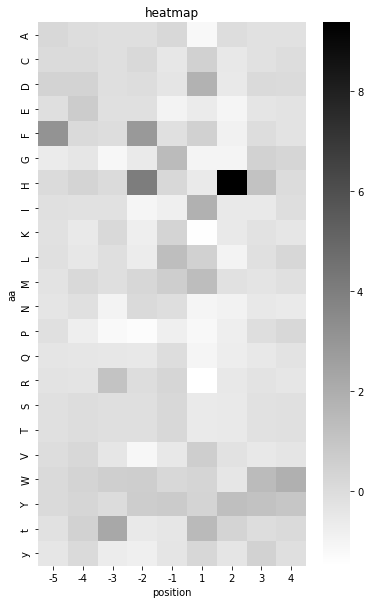

In [ ]:
plot_heatmap(t)

In [ ]:
info.source.value_counts()

PSPA    303
KS       87
Name: source, dtype: int64

In [ ]:
# check if training dataset has same order with the info
(info.kinase == t5.kinase).sum(), \
(info.kinase == t5_kd.kinase).sum(), \
(info.kinase == esm.kinase).sum(), \
(info.kinase == esm_kd.kinase).sum()

(390, 390, 390, 390)

In [ ]:
splits = get_splits(info, stratified='group',nfold=5)

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# kinase group in train set: 9
# kinase group in test set: 9
---------------------------
# kinase in train set: 312
---------------------------
# kinase in test set: 78
---------------------------
test set: ['EPHA3' 'FES' 'FLT3' 'FYN' 'EPHB1' 'EPHB3' 'FER' 'EPHB4' 'FLT4' 'FGFR1' 'EPHA5' 'TEK' 'DDR2' 'ZAP70' 'LIMK1' 'ULK3' 'JAK1' 'WEE1' 'TESK1' 'MAP2K3' 'AMPKA2' 'ATM' 'CAMK1D' 'CAMK2D' 'CAMK4' 'CAMKK1'
 'CK1D' 'CK1E' 'DYRK2' 'DYRK4' 'HGK' 'IKKE' 'JNK2' 'JNK3' 'KHS1' 'MAPKAPK5' 'MEK2' 'MSK2' 'NDR1' 'NEK6' 'NEK9' 'NIM1' 'NLK' 'OSR1' 'P38A' 'P38B' 'P90RSK' 'PAK1' 'PERK' 'PKCH' 'PKCI' 'PKN1' 'ROCK2'
 'RSK2' 'SIK' 'STLK3' 'TAK1' 'TSSK1' 'ALPHAK3' 'BMPR2' 'CDK10' 'CDK13' 'CDK14' 'CDKL5' 'GCN2' 'GRK4' 'IRE1' 'KHS2' 'MASTL' 'MLK4' 'MNK1' 'MRCKA' 'PRPK' 'QSK' 'SMMLCK' 'SSTK' 'ULK2' 'VRK1']


## Train DL

In [ ]:
seed_everything()

In [ ]:
num_t5 = len(t5_col)
num_esm = len(esm_col)
num_target = len(target_col)

In [ ]:
num_t5,num_esm, num_target

(1024, 1280, 210)

In [ ]:
def mlp_t5():
    return MLP_1(num_t5, num_target)

def mlp_esm():
    return MLP_1(num_esm, num_target)

def cnn_t5():
    return CNN1D_2(num_t5, num_target)

def cnn_esm():
    return CNN1D_2(num_esm, num_target)

In [ ]:
models = {
    'mlp_t5':    (mlp_t5, t5,    t5_col),
    'mlp_t5_kd': (mlp_t5, t5_kd, t5_col),
    'mlp_esm':   (mlp_esm,esm,   esm_col),
    'mlp_esm_kd':(mlp_esm,esm_kd,esm_col),
    'cnn_t5':    (cnn_t5, t5,    t5_col),
    'cnn_t5_kd': (cnn_t5, t5_kd, t5_col),
    'cnn_esm':   (cnn_esm,esm,   esm_col),
    'cnn_esm_kd':(cnn_esm,esm_kd,esm_col)
}

In [ ]:
%%time

oofs={}
metrics_list = []

n_epoch=20
lr = 3e-3

for save_name, (model_func, data, feat_col) in models.items():
    
    oof, metrics = train_dl_cv(data,
                           feat_col,
                           target_col, 
                           splits, 
                           model_func, 
                           save = save_name,
                           n_epoch=n_epoch,lr=lr)
    
    oofs[save_name] = oof
    metrics['model'] = save_name
    metrics_list.append(metrics)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.154047,0.993763,0.080863,0.080229,00:01
1,1.033500,0.957460,0.251623,0.239915,00:01
2,0.908174,0.879915,0.434919,0.403990,00:01
3,0.805384,0.804587,0.560596,0.495304,00:01
4,0.725529,0.720960,0.628532,0.571654,00:01
5,0.656491,0.599209,0.692632,0.614877,00:01
6,0.603124,0.513039,0.724522,0.655832,00:01
7,0.555976,0.479024,0.732275,0.665790,00:01
8,0.513584,0.460103,0.735400,0.682403,00:01
9,0.478237,0.461291,0.735585,0.669326,00:01


overall MSE: 0.4177
Average Pearson: 0.7472 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.140956,0.993235,0.083575,0.075205,00:01
1,1.011993,0.958387,0.244458,0.236904,00:01
2,0.889426,0.886061,0.442374,0.413279,00:01
3,0.795835,0.807503,0.563417,0.515726,00:01
4,0.711169,0.701166,0.652063,0.602737,00:01
5,0.645843,0.616948,0.670980,0.613756,00:01
6,0.590385,0.542628,0.694287,0.611596,00:01
7,0.544477,0.493557,0.716135,0.642213,00:01
8,0.505067,0.495106,0.710593,0.648736,00:01
9,0.469207,0.483776,0.718823,0.653112,00:01


overall MSE: 0.4233
Average Pearson: 0.7386 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.165929,0.997861,0.050772,0.028566,00:01
1,1.039540,0.966586,0.206035,0.189236,00:01
2,0.914809,0.892644,0.412268,0.377057,00:01
3,0.809839,0.814406,0.555799,0.476264,00:01
4,0.725071,0.712379,0.639749,0.585895,00:01
5,0.655595,0.602220,0.680939,0.629493,00:01
6,0.598713,0.537104,0.715591,0.644765,00:01
7,0.549589,0.476055,0.739973,0.675286,00:01
8,0.510118,0.444510,0.746331,0.681570,00:01
9,0.474679,0.458707,0.738142,0.676377,00:01


overall MSE: 0.3890
Average Pearson: 0.7670 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.145138,0.992893,0.085656,0.074035,00:01
1,1.027817,0.959737,0.239721,0.227646,00:01
2,0.905911,0.881654,0.443629,0.424223,00:01
3,0.807086,0.794142,0.573527,0.543761,00:01
4,0.727605,0.693271,0.642865,0.601084,00:01
5,0.662847,0.589507,0.702499,0.640313,00:01
6,0.610458,0.515101,0.726136,0.663075,00:01
7,0.562271,0.469750,0.734906,0.662374,00:01
8,0.520536,0.425143,0.761607,0.686464,00:01
9,0.483968,0.423267,0.763724,0.680789,00:01


overall MSE: 0.3779
Average Pearson: 0.7735 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.171297,0.997939,0.050111,0.040568,00:01
1,1.045996,0.964800,0.220317,0.198966,00:01
2,0.917384,0.886729,0.437603,0.402385,00:01
3,0.816893,0.811052,0.554054,0.492507,00:01
4,0.730609,0.707229,0.615462,0.570250,00:01
5,0.663249,0.611400,0.684933,0.605848,00:01
6,0.605722,0.542345,0.697075,0.611762,00:01
7,0.557211,0.482583,0.726528,0.633111,00:01
8,0.516083,0.491525,0.713217,0.636467,00:01
9,0.478804,0.467066,0.731536,0.634731,00:01


overall MSE: 0.4184
Average Pearson: 0.7448 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.128783,0.993710,0.079545,0.087242,00:01
1,1.000408,0.954827,0.252600,0.259849,00:01
2,0.877500,0.872050,0.445186,0.440904,00:01
3,0.781121,0.788291,0.598598,0.556018,00:01
4,0.703877,0.698109,0.673864,0.624578,00:01
5,0.644518,0.605176,0.698570,0.616493,00:01
6,0.594482,0.529415,0.725192,0.667000,00:01
7,0.552536,0.511411,0.711317,0.637322,00:01
8,0.514493,0.471762,0.727841,0.691696,00:01
9,0.485739,0.473458,0.731075,0.673806,00:01


overall MSE: 0.3972
Average Pearson: 0.7600 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.110761,0.996697,0.057758,0.075487,00:01
1,0.978502,0.956851,0.282827,0.300056,00:01
2,0.852812,0.873396,0.474011,0.450219,00:01
3,0.753090,0.793904,0.586377,0.521912,00:01
4,0.680767,0.697122,0.648115,0.590710,00:01
5,0.621360,0.626566,0.678537,0.621998,00:01
6,0.573299,0.537844,0.700038,0.619934,00:01
7,0.537447,0.564759,0.671423,0.581094,00:01
8,0.501783,0.530610,0.685135,0.612027,00:01
9,0.471651,0.471819,0.728918,0.666515,00:01


overall MSE: 0.3999
Average Pearson: 0.7565 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.131063,0.996462,0.059773,0.041874,00:01
1,1.003610,0.958448,0.260307,0.226585,00:01
2,0.877091,0.879808,0.460443,0.419428,00:01
3,0.776283,0.795005,0.584367,0.507475,00:01
4,0.695550,0.729284,0.658256,0.593127,00:01
5,0.635156,0.610224,0.706382,0.641893,00:01
6,0.587124,0.511825,0.723481,0.670150,00:01
7,0.545906,0.471957,0.748007,0.674919,00:01
8,0.508820,0.440248,0.749761,0.682432,00:01
9,0.477320,0.445300,0.748759,0.692518,00:01


overall MSE: 0.3703
Average Pearson: 0.7833 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.111100,0.984469,0.148462,0.118590,00:01
1,0.977842,0.943770,0.310783,0.289653,00:01
2,0.871553,0.864395,0.471983,0.428511,00:01
3,0.776905,0.780677,0.614120,0.545000,00:01
4,0.699287,0.684117,0.686196,0.603511,00:01
5,0.637435,0.604981,0.726525,0.636420,00:01
6,0.587340,0.473186,0.764501,0.693565,00:01
7,0.547684,0.479824,0.727440,0.655271,00:01
8,0.513541,0.451349,0.753496,0.668923,00:01
9,0.479716,0.409409,0.776387,0.686997,00:01


overall MSE: 0.3444
Average Pearson: 0.8022 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.138863,0.993372,0.082757,0.072170,00:01
1,1.009768,0.951483,0.274195,0.258487,00:01
2,0.884887,0.871585,0.454884,0.412056,00:01
3,0.790021,0.784916,0.595855,0.538802,00:01
4,0.708776,0.690470,0.686383,0.600683,00:01
5,0.648803,0.601382,0.698563,0.639437,00:01
6,0.599950,0.540712,0.707360,0.610571,00:01
7,0.556581,0.471006,0.733336,0.644909,00:01
8,0.521624,0.452386,0.745504,0.674814,00:01
9,0.488039,0.480375,0.722168,0.629938,00:01


overall MSE: 0.3734
Average Pearson: 0.7825 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.157673,0.998462,0.048070,0.072969,00:01
1,1.037905,0.945200,0.284254,0.297389,00:01
2,0.916484,0.800898,0.532123,0.505515,00:01
3,0.824315,0.674872,0.625628,0.574711,00:01
4,0.748077,0.604842,0.635903,0.567009,00:01
5,0.689846,0.538024,0.685815,0.604766,00:01
6,0.641608,0.501118,0.706454,0.644766,00:01
7,0.597043,0.468152,0.729283,0.674768,00:01
8,0.557734,0.491791,0.713333,0.664789,00:01
9,0.523974,0.472747,0.727143,0.669441,00:01


overall MSE: 0.3856
Average Pearson: 0.7633 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.148871,0.993806,0.081569,0.063176,00:01
1,1.024885,0.942724,0.330757,0.302565,00:01
2,0.905095,0.809047,0.543201,0.513134,00:01
3,0.810084,0.704233,0.623344,0.574213,00:01
4,0.733200,0.607658,0.646933,0.594417,00:01
5,0.670995,0.564638,0.659830,0.616129,00:01
6,0.622740,0.537306,0.680612,0.617730,00:01
7,0.581736,0.507870,0.701577,0.640984,00:01
8,0.542354,0.515192,0.696285,0.636736,00:01
9,0.510413,0.531217,0.687404,0.617385,00:01


overall MSE: 0.4367
Average Pearson: 0.7310 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.156618,0.996993,0.056145,0.064842,00:01
1,1.034022,0.950679,0.278912,0.284957,00:01
2,0.912812,0.824764,0.525375,0.495985,00:01
3,0.815307,0.702473,0.632620,0.554350,00:01
4,0.741813,0.588826,0.675763,0.599057,00:01
5,0.680163,0.526534,0.691813,0.620772,00:01
6,0.628032,0.499857,0.708549,0.635667,00:01
7,0.581624,0.473593,0.727864,0.664521,00:01
8,0.541849,0.459929,0.734957,0.674673,00:01
9,0.508627,0.450476,0.741458,0.676974,00:01


overall MSE: 0.3975
Average Pearson: 0.7645 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.159021,0.994149,0.078490,0.050288,00:01
1,1.037169,0.951734,0.294549,0.267674,00:01
2,0.919539,0.824703,0.531176,0.498259,00:01
3,0.823436,0.710149,0.607041,0.516334,00:01
4,0.744455,0.589703,0.672932,0.584959,00:01
5,0.679118,0.514884,0.701929,0.633019,00:01
6,0.626607,0.509054,0.700702,0.619701,00:01
7,0.588692,0.490848,0.714870,0.639465,00:01
8,0.554123,0.465737,0.733084,0.654866,00:01
9,0.515814,0.469562,0.728755,0.643777,00:01


overall MSE: 0.3990
Average Pearson: 0.7607 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.137612,0.994000,0.078814,0.056758,00:01
1,1.023317,0.943398,0.318036,0.285128,00:01
2,0.904741,0.811796,0.544389,0.492103,00:01
3,0.814181,0.683793,0.634993,0.545088,00:01
4,0.736907,0.581590,0.680457,0.597002,00:01
5,0.676377,0.519496,0.695451,0.618372,00:01
6,0.628734,0.512692,0.699184,0.605052,00:01
7,0.585340,0.521013,0.696463,0.626780,00:01
8,0.548112,0.464780,0.731850,0.645645,00:01
9,0.513222,0.485793,0.717376,0.619378,00:01


overall MSE: 0.4193
Average Pearson: 0.7586 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.136482,0.993696,0.080199,0.085662,00:01
1,0.998372,0.923513,0.385841,0.354111,00:01
2,0.872176,0.756011,0.592829,0.549260,00:01
3,0.775923,0.635067,0.660251,0.602803,00:01
4,0.702748,0.526281,0.705283,0.634054,00:01
5,0.647198,0.522564,0.698861,0.627824,00:01
6,0.597791,0.489143,0.718212,0.664088,00:01
7,0.561085,0.517959,0.694381,0.615827,00:01
8,0.527388,0.451737,0.740705,0.679675,00:01
9,0.493225,0.438324,0.749938,0.707114,00:01


overall MSE: 0.3747
Average Pearson: 0.7680 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.126146,0.994451,0.074958,0.072940,00:01
1,0.992778,0.921305,0.378173,0.347688,00:01
2,0.870068,0.759877,0.573249,0.527383,00:01
3,0.775533,0.644609,0.644986,0.587326,00:01
4,0.697560,0.581562,0.665445,0.598124,00:01
5,0.643023,0.548444,0.674107,0.601390,00:01
6,0.597180,0.528359,0.687243,0.619392,00:01
7,0.555703,0.480282,0.720927,0.675910,00:01
8,0.521891,0.466492,0.730493,0.675750,00:01
9,0.491663,0.466466,0.731582,0.673130,00:01


overall MSE: 0.4034
Average Pearson: 0.7568 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.124082,1.000890,0.025263,0.032386,00:01
1,0.990205,0.933668,0.369440,0.343749,00:01
2,0.874709,0.771003,0.587052,0.541818,00:01
3,0.783245,0.638195,0.652622,0.597745,00:01
4,0.710708,0.558960,0.678355,0.600784,00:01
5,0.654200,0.515192,0.701643,0.643724,00:01
6,0.603523,0.469243,0.728574,0.670986,00:01
7,0.563172,0.514160,0.697029,0.620195,00:01
8,0.527461,0.492941,0.712300,0.636880,00:01
9,0.496621,0.438729,0.749249,0.698523,00:01


overall MSE: 0.3782
Average Pearson: 0.7812 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.122446,0.995197,0.070141,0.057839,00:01
1,0.993662,0.926829,0.389817,0.347008,00:01
2,0.873179,0.771662,0.602927,0.548822,00:01
3,0.781082,0.638639,0.680993,0.596084,00:01
4,0.709751,0.527253,0.708673,0.622247,00:01
5,0.653177,0.476999,0.729322,0.640477,00:01
6,0.603732,0.474914,0.724693,0.621398,00:01
7,0.565161,0.436976,0.750389,0.682896,00:01
8,0.533213,0.435934,0.754656,0.661643,00:01
9,0.502031,0.399242,0.778864,0.701386,00:01


overall MSE: 0.3507
Average Pearson: 0.7909 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.133101,0.996229,0.062005,0.046389,00:01
1,0.996671,0.924041,0.393522,0.339823,00:01
2,0.878841,0.769787,0.600870,0.544570,00:01
3,0.783613,0.630914,0.678652,0.599448,00:01
4,0.708441,0.512700,0.712528,0.627240,00:01
5,0.648157,0.505964,0.704126,0.623504,00:01
6,0.596509,0.458010,0.736221,0.649767,00:01
7,0.556387,0.475411,0.729549,0.646778,00:01
8,0.524189,0.466897,0.734682,0.663400,00:01
9,0.493333,0.442036,0.747183,0.660340,00:01


overall MSE: 0.3725
Average Pearson: 0.7815 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.292544,0.989465,0.116011,0.109405,00:04
1,1.142734,0.991869,0.100687,0.042590,00:01
2,1.021166,1.054265,0.164518,0.115665,00:01
3,0.946030,0.983256,0.260691,0.208587,00:01
4,0.877899,0.945536,0.289812,0.283952,00:02
5,0.806079,0.700232,0.563017,0.523097,00:01
6,0.728828,0.627072,0.617049,0.557381,00:01
7,0.653791,0.481928,0.721406,0.645876,00:01
8,0.589306,0.447124,0.749204,0.668335,00:01
9,0.527541,0.438720,0.753606,0.682532,00:01


overall MSE: 0.3691
Average Pearson: 0.7754 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.280892,0.989775,0.106935,0.080704,00:02
1,1.139460,0.983054,0.131488,0.064454,00:01
2,1.023331,1.085983,0.099590,0.051320,00:01
3,0.932097,1.008756,0.229172,0.224889,00:01
4,0.860198,0.809107,0.436972,0.383236,00:01
5,0.794526,0.802949,0.505577,0.465394,00:02
6,0.734285,0.681683,0.582518,0.517996,00:01
7,0.665784,0.555346,0.682581,0.627427,00:01
8,0.595424,0.507221,0.715518,0.657850,00:01
9,0.533775,0.482111,0.729736,0.668044,00:01


overall MSE: 0.4010
Average Pearson: 0.7651 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.268538,0.989308,0.112892,0.063198,00:01
1,1.125541,0.984390,0.130679,0.085495,00:01
2,1.014183,1.182768,0.041443,0.019458,00:01
3,0.935534,0.891649,0.329646,0.284717,00:01
4,0.864271,0.769452,0.480573,0.482503,00:01
5,0.800483,0.686034,0.561784,0.472785,00:01
6,0.734342,0.560399,0.663065,0.587283,00:01
7,0.661612,0.493249,0.711880,0.632056,00:01
8,0.591530,0.471516,0.732291,0.647952,00:01
9,0.531793,0.426530,0.758131,0.686342,00:01


overall MSE: 0.3784
Average Pearson: 0.7729 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.285269,0.990208,0.107578,0.077208,00:01
1,1.135616,0.982261,0.135285,0.109125,00:01
2,1.017804,1.258903,0.061325,0.067551,00:01
3,0.948030,1.043126,0.207390,0.235657,00:01
4,0.876326,0.817656,0.427716,0.363078,00:01
5,0.810635,0.750633,0.514241,0.421862,00:01
6,0.740500,0.605633,0.633040,0.538895,00:01
7,0.668496,0.468002,0.734820,0.661240,00:01
8,0.599872,0.444961,0.747589,0.659324,00:01
9,0.536926,0.394913,0.778070,0.700332,00:01


overall MSE: 0.3726
Average Pearson: 0.7783 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.284542,0.989482,0.110908,0.076821,00:02
1,1.136575,1.001484,0.083966,0.004165,00:01
2,1.022551,0.992045,0.183526,0.172091,00:01
3,0.947053,0.971159,0.319269,0.245793,00:01
4,0.879423,0.991022,0.268215,0.172019,00:01
5,0.809498,0.758455,0.501788,0.427878,00:01
6,0.738233,0.655159,0.616733,0.535067,00:01
7,0.663848,0.509706,0.711039,0.622114,00:01
8,0.595070,0.457961,0.739392,0.644187,00:01
9,0.528692,0.424382,0.761139,0.671177,00:01


overall MSE: 0.3832
Average Pearson: 0.7703 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.248910,0.990329,0.107553,0.075002,00:01
1,1.091407,1.004232,0.057023,0.063556,00:01
2,0.981395,1.028895,0.110138,0.062971,00:01
3,0.904417,0.934115,0.277484,0.224396,00:01
4,0.842598,0.876274,0.352068,0.285614,00:01
5,0.787378,0.721206,0.530349,0.449411,00:01
6,0.716401,0.627813,0.616593,0.541714,00:02
7,0.648505,0.519202,0.695117,0.639158,00:02
8,0.587389,0.469505,0.737564,0.670411,00:02
9,0.533930,0.404412,0.772227,0.705982,00:02


overall MSE: 0.3661
Average Pearson: 0.7832 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.260543,0.989198,0.117010,0.070382,00:02
1,1.092462,0.988899,0.111428,0.067119,00:01
2,0.979237,0.987732,0.183323,0.119536,00:01
3,0.907215,0.909729,0.302536,0.280490,00:01
4,0.841430,0.859976,0.375066,0.350604,00:01
5,0.778112,0.675421,0.570308,0.514938,00:01
6,0.713817,0.634272,0.605147,0.529246,00:02
7,0.651417,0.493535,0.714316,0.642089,00:02
8,0.588797,0.464606,0.738157,0.681146,00:01
9,0.535079,0.411608,0.769504,0.705002,00:01


overall MSE: 0.3568
Average Pearson: 0.8002 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.241334,0.987173,0.126982,0.038944,00:02
1,1.087275,0.986407,0.125084,0.033662,00:02
2,0.972466,1.049425,0.117816,0.137235,00:01
3,0.897240,0.852623,0.392091,0.301257,00:01
4,0.835681,0.934227,0.369359,0.343481,00:02
5,0.774235,0.736187,0.515436,0.426457,00:01
6,0.705956,0.580412,0.647782,0.570580,00:01
7,0.640253,0.490460,0.713847,0.633763,00:01
8,0.580089,0.416725,0.766332,0.695887,00:01
9,0.526275,0.393426,0.781002,0.704387,00:01


overall MSE: 0.3327
Average Pearson: 0.8122 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.251677,0.986292,0.133228,0.061990,00:02
1,1.102669,1.015790,0.020404,-0.018939,00:01
2,0.999381,0.971351,0.236474,0.214251,00:01
3,0.927511,1.109817,0.222932,0.207917,00:02
4,0.860651,0.992894,0.362856,0.272478,00:01
5,0.796436,0.707508,0.542654,0.493122,00:01
6,0.726586,0.593804,0.638483,0.554444,00:01
7,0.660332,0.448944,0.742450,0.652884,00:02
8,0.595792,0.413435,0.766413,0.671086,00:01
9,0.539051,0.383802,0.785490,0.699669,00:01


overall MSE: 0.3211
Average Pearson: 0.8147 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.236935,0.988487,0.122808,0.116170,00:02
1,1.088595,0.995019,0.099203,0.074631,00:01
2,0.978199,1.091740,0.126714,0.104141,00:01
3,0.907331,1.035308,0.227215,0.194727,00:01
4,0.851115,0.803582,0.443475,0.369602,00:01
5,0.781886,0.742443,0.509365,0.444919,00:01
6,0.720206,0.607618,0.638965,0.565104,00:01
7,0.653392,0.471417,0.731905,0.639212,00:01
8,0.594954,0.433168,0.754789,0.674654,00:02
9,0.537510,0.395863,0.781489,0.708912,00:02


overall MSE: 0.3398
Average Pearson: 0.8016 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.302429,0.987325,0.126596,0.101961,00:02
1,1.155154,0.975091,0.165441,0.156144,00:02
2,1.051807,1.047461,0.137457,0.101728,00:02
3,0.978245,0.838732,0.402352,0.362293,00:01
4,0.916060,0.763447,0.493328,0.391600,00:02
5,0.849674,0.650760,0.610215,0.507070,00:01
6,0.779025,0.765222,0.621145,0.574651,00:01
7,0.713487,0.650561,0.639459,0.584059,00:01
8,0.648538,0.513293,0.720456,0.640336,00:01
9,0.588102,0.451876,0.745794,0.665660,00:02


overall MSE: 0.3814
Average Pearson: 0.7636 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.288849,0.991512,0.098513,0.104055,00:01
1,1.149817,0.969611,0.178000,0.149233,00:01
2,1.056316,0.957713,0.223003,0.183647,00:02
3,0.983231,0.871047,0.373427,0.280447,00:02
4,0.907145,0.804289,0.452214,0.404478,00:01
5,0.843737,0.788859,0.564525,0.520059,00:01
6,0.769427,0.761436,0.613170,0.541585,00:01
7,0.697985,0.572734,0.686768,0.620936,00:01
8,0.629333,0.531864,0.696246,0.631403,00:01
9,0.568340,0.498049,0.716345,0.667771,00:01


overall MSE: 0.4244
Average Pearson: 0.7512 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.294832,0.993058,0.086690,0.041377,00:01
1,1.149183,0.988674,0.108200,0.064975,00:01
2,1.049579,1.063563,0.110334,0.096180,00:01
3,0.991086,0.833912,0.408381,0.332441,00:01
4,0.943465,0.803314,0.443683,0.391172,00:01
5,0.868038,0.660401,0.607326,0.534908,00:01
6,0.800216,0.741996,0.580026,0.476736,00:01
7,0.730816,0.563737,0.688017,0.608828,00:01
8,0.667033,0.567450,0.708758,0.632448,00:01
9,0.602029,0.455588,0.744640,0.669595,00:01


overall MSE: 0.3880
Average Pearson: 0.7684 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.297134,0.992432,0.089417,0.040924,00:02
1,1.153744,0.995849,0.087174,0.034802,00:02
2,1.053385,0.965197,0.214082,0.146169,00:01
3,0.996689,0.896478,0.353285,0.348727,00:01
4,0.926985,0.790891,0.459010,0.366767,00:01
5,0.859994,0.847036,0.526804,0.472004,00:01
6,0.789911,0.670244,0.619232,0.534482,00:01
7,0.719859,0.531346,0.698154,0.614017,00:02
8,0.657427,0.504494,0.711225,0.630594,00:02
9,0.594539,0.460375,0.741614,0.657430,00:02


overall MSE: 0.3846
Average Pearson: 0.7662 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.280601,0.987249,0.135629,0.125721,00:01
1,1.143126,0.981064,0.138952,0.115609,00:01
2,1.044881,0.970373,0.223964,0.169955,00:01
3,0.975163,0.851138,0.386579,0.332334,00:01
4,0.915974,0.817548,0.429852,0.314103,00:02
5,0.844742,0.658974,0.638312,0.543933,00:02
6,0.774957,0.675945,0.643501,0.548340,00:01
7,0.709393,0.574169,0.696119,0.585268,00:01
8,0.645132,0.530699,0.696703,0.604004,00:02
9,0.583587,0.451727,0.742912,0.655546,00:01


overall MSE: 0.3888
Average Pearson: 0.7725 
------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.253576,0.993299,0.084734,0.056130,00:02
1,1.098991,0.982216,0.134073,0.078020,00:01
2,0.991126,0.968159,0.204686,0.154167,00:01
3,0.916993,0.769684,0.494121,0.431679,00:01
4,0.848817,0.699939,0.551495,0.492341,00:02
5,0.786676,0.684427,0.641190,0.534389,00:01
6,0.720431,0.668424,0.671995,0.569518,00:01
7,0.657140,0.532488,0.724972,0.626365,00:02
8,0.599847,0.503078,0.742054,0.680196,00:01
9,0.544374,0.430222,0.768765,0.704063,00:02


overall MSE: 0.3592
Average Pearson: 0.7813 
------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.229177,0.989660,0.108738,0.043703,00:02
1,1.080249,0.984985,0.125213,0.108477,00:02
2,0.978429,0.947816,0.231414,0.171291,00:01
3,0.911561,0.922546,0.290002,0.256684,00:01
4,0.847492,0.711955,0.548586,0.518456,00:01
5,0.786505,0.700665,0.603755,0.526356,00:02
6,0.726127,0.623342,0.677597,0.608144,00:02
7,0.657878,0.522822,0.721908,0.642809,00:02
8,0.593254,0.483774,0.735289,0.669383,00:02
9,0.538243,0.432575,0.758054,0.692037,00:02


overall MSE: 0.3781
Average Pearson: 0.7831 
------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.236020,0.995248,0.070178,0.027696,00:01
1,1.078264,0.988759,0.110743,0.050422,00:01
2,0.984304,0.938209,0.253295,0.167887,00:01
3,0.937014,0.888574,0.363953,0.332320,00:01
4,0.864709,0.737954,0.516128,0.468583,00:01
5,0.802079,0.694279,0.601614,0.525180,00:01
6,0.731031,0.581466,0.688198,0.585389,00:01
7,0.668890,0.576273,0.708466,0.627421,00:01
8,0.609645,0.487239,0.746917,0.665989,00:01
9,0.552273,0.419803,0.770106,0.700640,00:01


overall MSE: 0.3419
Average Pearson: 0.8041 
------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.222317,0.993610,0.080199,0.032400,00:02
1,1.076854,0.977526,0.150822,0.129489,00:01
2,0.980216,0.998324,0.164397,0.158476,00:02
3,0.913132,0.770909,0.481249,0.440876,00:01
4,0.859254,0.649468,0.593107,0.492686,00:01
5,0.800511,0.686524,0.628884,0.560609,00:01
6,0.739962,0.612573,0.670090,0.540904,00:01
7,0.675889,0.531022,0.705821,0.602978,00:01
8,0.611711,0.439105,0.755904,0.676651,00:01
9,0.552348,0.389951,0.784729,0.703547,00:01


overall MSE: 0.3232
Average Pearson: 0.8073 
------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.238034,0.995568,0.067444,0.017039,00:02
1,1.087779,0.997393,0.086055,0.001116,00:02
2,0.986789,0.962331,0.221712,0.125929,00:01
3,0.921382,0.781944,0.474640,0.396243,00:02
4,0.856494,0.741954,0.513045,0.422718,00:02
5,0.795871,0.652096,0.633885,0.545384,00:02
6,0.734708,0.623018,0.692585,0.576608,00:02
7,0.667443,0.561336,0.715499,0.607036,00:02
8,0.607193,0.460601,0.746010,0.651354,00:02
9,0.554969,0.463469,0.755858,0.669316,00:01


overall MSE: 0.3379
Average Pearson: 0.8071 
CPU times: user 3min 16s, sys: 17min 23s, total: 20min 40s
Wall time: 22min 42s


In [ ]:
score = pd.concat(metrics_list)

In [ ]:
score.sort_values('mse').head()

,fold,mse,pearson_avg,model
3,3,0.321140,0.814740,cnn_t5_kd
3,3,0.323208,0.807320,cnn_esm_kd
2,2,0.332671,0.812157,cnn_t5_kd
4,4,0.337893,0.807076,cnn_esm_kd
4,4,0.339779,0.801619,cnn_t5_kd


## Train ML

In [ ]:
# Define feature sets and their corresponding column names
feature_sets = {
    't5':(t5,t5_col),
    't5_kd':(t5_kd,t5_col),
    'esm':(esm,esm_col),
    'esm_kd':(esm_kd,esm_col),
}

In [ ]:
# Dictionary of ML models
ml_models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(0.1), # L1 regularization # changing alpha does not change the result
    'Ridge': Ridge(alpha=0.1), # L2 regularization
    'ElasticNet': ElasticNet(0.1), # Combine L1 and L2
    
    # 'SVR':SVR(C=10,gamma=1),
    'DecisionTreeRegressor': DecisionTreeRegressor(), # not very good
    'KNN': KNeighborsRegressor(n_neighbors=3), # compared with others, n=3 gives the best results
    # 'XGBRegressor': XGBRegressor(), #slow without gpu
    # 'RandomForestRegressor': RandomForestRegressor() # slow, use cuml to use gpu
                                      }

In [ ]:
metrics_list2 = []
oofs2 = {}

for model_name, model in ml_models.items():
    for feature_name, (data, feat_col) in feature_sets.items():
        
        # get model name for save
        save_name = f'{model_name}_{feature_name}'
        print('------------------',save_name,'------------------')
        
        
        # if want to save model, just remove save_name
        # oof, metrics = train_ml_cv(data, feat_col, target_col, splits,model,save_name)
        
        # train
        oof, metrics = train_ml_cv(data, feat_col, target_col, splits, model)
        
        # save metrics
        metrics['model'] = save_name
        metrics_list2.append(metrics)
        
        # save oof
        oofs2[save_name] = oof

------------------ LinearRegression_t5 ------------------
------ fold: 0 --------
LinearRegression()
overall MSE: 0.8305
Average Pearson: 0.6931 
------ fold: 1 --------
LinearRegression()
overall MSE: 0.6924
Average Pearson: 0.6997 
------ fold: 2 --------
LinearRegression()
overall MSE: 0.7312
Average Pearson: 0.7086 
------ fold: 3 --------
LinearRegression()
overall MSE: 0.7582
Average Pearson: 0.6908 
------ fold: 4 --------
LinearRegression()
overall MSE: 0.7260
Average Pearson: 0.6874 
------------------ LinearRegression_t5_kd ------------------
------ fold: 0 --------
LinearRegression()
overall MSE: 0.8763
Average Pearson: 0.7168 
------ fold: 1 --------
LinearRegression()
overall MSE: 0.6405
Average Pearson: 0.7313 
------ fold: 2 --------
LinearRegression()
overall MSE: 0.7465
Average Pearson: 0.7429 
------ fold: 3 --------
LinearRegression()
overall MSE: 0.6453
Average Pearson: 0.7328 
------ fold: 4 --------
LinearRegression()
overall MSE: 0.7906
Average Pearson: 0.7263 
-

In [ ]:
score2 = pd.concat(metrics_list2)

## Save results

### metrics

In [ ]:
score2['type'] = 'ML'
score['type']='DL'

In [ ]:
scores = pd.concat([score,score2])

In [ ]:
scores.sort_values('pearson_avg',ascending=False)

,fold,mse,pearson_avg,model,type
3,3,0.321140,0.814740,cnn_t5_kd,DL
2,2,0.332671,0.812157,cnn_t5_kd,DL
3,3,0.323208,0.807320,cnn_esm_kd,DL
4,4,0.337893,0.807076,cnn_esm_kd,DL
2,2,0.341916,0.804054,cnn_esm_kd,DL
...,...,...,...,...,...
2,2,0.870463,0.361619,Lasso_t5,ML
4,4,0.871231,0.359918,ElasticNet_t5,ML
4,4,0.871660,0.359292,ElasticNet_t5_kd,ML
4,4,0.871864,0.359087,Lasso_t5,ML


In [ ]:
scores.to_csv('raw/scores.csv',index=False)

### oof

In [ ]:
len(oofs2),len(oofs)

(24, 8)

In [ ]:
oofs2.keys(),oofs.keys()

(dict_keys(['LinearRegression_t5', 'LinearRegression_t5_kd', 'LinearRegression_esm', 'LinearRegression_esm_kd', 'Lasso_t5', 'Lasso_t5_kd', 'Lasso_esm', 'Lasso_esm_kd', 'Ridge_t5', 'Ridge_t5_kd', 'Ridge_esm', 'Ridge_esm_kd', 'ElasticNet_t5', 'ElasticNet_t5_kd', 'ElasticNet_esm', 'ElasticNet_esm_kd', 'DecisionTreeRegressor_t5', 'DecisionTreeRegressor_t5_kd', 'DecisionTreeRegressor_esm', 'DecisionTreeRegressor_esm_kd', 'KNN_t5', 'KNN_t5_kd', 'KNN_esm', 'KNN_esm_kd']),
 dict_keys(['mlp_t5', 'mlp_t5_kd', 'mlp_esm', 'mlp_esm_kd', 'cnn_t5', 'cnn_t5_kd', 'cnn_esm', 'cnn_esm_kd']))

In [ ]:
OOF = {**oofs, **oofs2}

In [ ]:
len(OOF)

32

In [ ]:
# to save the dictionary
save_pickle('raw/oof.pkl',OOF)

In [ ]:
# to load
dd  = load_pickle('raw/oof.pkl')

len(dd)

32